## TimeShelf: Book Recommendations Across Time and Style

In [421]:
from collections import Counter, defaultdict
from gensim.corpora.dictionary import Dictionary
from gensim.corpora.textcorpus import lower_to_unicode, strip_multiple_whitespaces
from gensim.corpora.textcorpus import remove_short, remove_stopwords
from gensim import corpora, models, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.utils import deaccent, simple_tokenize
# from gensim.utils import lemmatize  # Use nltk.stem.WordNetLemmatizer instead
# import gutenberg.acquire as gacquire
# import gutenberg.query as gquery  # print(gquery.list_supported_metadatas())
from hashlib import md5
import imp
import logging
from math import log10
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
from os import listdir
from os.path import isdir, isfile
from pymongo import MongoClient, InsertOne, DeleteOne, ReplaceOne
from random import shuffle
import re
from sklearn.utils import resample
import sys
import zipfile

# Config (MongoDB)

In [440]:
mongo_client = MongoClient()
assert('local' in mongo_client.database_names())
mongo_local_db = mongo_client.local
# mongo_local_db.create_collection('timeshelf_config')
timeshelf_config = mongo_local_db.get_collection('timeshelf_config')
mongo_requests = [InsertOne({'config': 'books_per_decade', 'GUTENBERG_BOOKS_PER_DECADE': 2})
                  , InsertOne({'config': 'max_header_lines', 'GUTENBERG_MAX_HEADER_LINES': 300})]
mongo_result = mongo_local_db.timeshelf_config.bulk_write(mongo_requests)

In [441]:
mongo_requests

[InsertOne({'config': 'books_per_decade', 'GUTENBERG_BOOKS_PER_DECADE': 2, '_id': ObjectId('5aa67cf27aec09f27c0484c1')}),
 InsertOne({'config': 'max_header_lines', 'GUTENBERG_MAX_HEADER_LINES': 300, '_id': ObjectId('5aa67cf27aec09f27c0484c2')})]

In [442]:
mongo_result.bulk_api_result

{'nInserted': 2,
 'nMatched': 0,
 'nModified': 0,
 'nRemoved': 0,
 'nUpserted': 0,
 'upserted': [],
 'writeConcernErrors': [],
 'writeErrors': []}

In [443]:
for timeshelf_config_doc in timeshelf_config.find():
    print(timeshelf_config_doc)

{'_id': ObjectId('5aa6790b7aec09f27c0484be'), 'GUTENBERG_BOOKS_PER_DECADE': 2}
{'_id': ObjectId('5aa6790b7aec09f27c0484bf'), 'GUTENBERG_MAX_HEADER_LINES': 300}
{'_id': ObjectId('5aa67cf27aec09f27c0484c1'), 'config': 'books_per_decade', 'GUTENBERG_BOOKS_PER_DECADE': 2}
{'_id': ObjectId('5aa67cf27aec09f27c0484c2'), 'config': 'max_header_lines', 'GUTENBERG_MAX_HEADER_LINES': 300}


In [446]:
books_per_decade = timeshelf_config.find_one({'config': 'books_per_decade'})['GUTENBERG_BOOKS_PER_DECADE']

In [447]:
books_per_decade

2

In [449]:
max_header_lines = timeshelf_config.find_one({'config': 'max_header_lines'})['GUTENBERG_MAX_HEADER_LINES']

In [450]:
max_header_lines

300

# Config (Other)

In [4]:
DTM_PATH = os.environ.get('DTM_PATH', None)
if not DTM_PATH:
    raise ValueError("Error: DTM_PATH must be set")

In [5]:
MODULE_EXTENSIONS = ('.py', '.pyc', '.pyo')

In [6]:
ZHOME = '../data/gutenberg_books_en/aleph.gutenberg.org/'

In [297]:
GUTENBERG_BOOKS_PER_DECADE = 2
GUTENBERG_MAX_HEADER_LINES = 300

GUTENBERG_DOWNLOAD_DIR = os.environ['GUTENBERG_DOWNLOAD_DIR']
GUTENBERG_MIN_DECADE = 1600
GUTENBERG_MAX_DECADE = 2010

GUTENBERG_STOPWORDS = stopwords.words('english')
GUTENBERG_STOPWORDS.extend(gensim.parsing.preprocessing.STOPWORDS)
GUTENBERG_STOPWORDS.extend("""January February March April May June
    July August September October November December
    time year
    one two three four five six seven eight nine ten
    eleven twelve thirteen fourteen fifteen sixteen seventeen eighteen nineteen twenty
    """.lower().split())  

# Sample Data

In [9]:
test_book_data = [ [1, 'Lolita',                             'Vladimir Nabokov',    1955 ]
                 , [2, 'The Great Gatsby',                   'F. Scott Fitzgerald', 1925 ]
                 , [3, 'In Search of Lost Time',             'Marcel Proust',       1922 ]
                 , [4, 'Ulysses',                            'James Joyce',         1922 ]
                 , [5, 'Dubliners',                          'James Joyce',         1914 ]
                 , [6, 'Anna Karenina',                      'Leo Tolstoy',         1877 ]
                 , [7, 'Madame Bovary',                      'Gustave Flaubert',    1857 ]
                 , [8, 'War and Peace',                      'Leo Tolstoy',         1869 ]
                 , [9, 'The Adventures of Huckleberry Finn', 'Mark Twain',          1884 ]
                 , [10, 'Middlemarch',                       'George Eliot',        1871 ]
                 ]

# Data Location Info

In [10]:
sample_book_ids = [6001, 7001, 8000, 9043, 10000, 20001, 30000, 40000, 50000]
excluded_book_ids = [89, 3290, 5192, 10681, 13526, 15824, 18251]  # Extra download files
excluded_book_ids.extend([2609, 16762, 11813, 14021, 29274, 35724, 35335])  # Files out of place
excluded_book_ids.extend([1])  # Different format

# Classes

In [402]:
# From https://markroxor.github.io/gensim/static/notebooks/dtm_example.html
class DTMcorpus(corpora.textcorpus.TextCorpus):
    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

In [363]:
# TODO: Upsampling & downsampling to reach GUTENBERG_BOOKS_PER_DECADE
class GutenbergCorpus(corpora.textcorpus.TextCorpus):
    def __init__(self, books, num_books_per_decade=GUTENBERG_BOOKS_PER_DECADE, seed=0):
        self.books = books
        self.seed = seed
        self.num_books_per_decade = num_books_per_decade
        self.set_books_by_decade() # dict: K=int; V=book
        self.decades = sorted(self.books_by_decade.keys())
        self.set_selected_book_ids_by_decade()

        # Creation of the Dictionary uses:
        #   0+ character filters
        #   a tokenizer
        #   0+ token filters
        self.character_filters = [lower_to_unicode, deaccent, strip_multiple_whitespaces]
        self.tokenizer = simple_tokenize
        self.token_filters = [remove_short, remove_stopwords]

        self.dictionary = Dictionary(self.get_texts())
        self.dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=100000)
        
        self.metadata=None

    def __len__(self):
        # return sum( [len(self.books_by_decade[decade])
        #             for decade in self.books_by_decade]
        #           )
        return self.num_books_per_decade * len(self.decades)
    
    # Ensure that the texts returned are ordered by decade (i.e., time slice)
    # Returned tokens are inserted the instance's dictionary property.
    # Note: gensim/corpora/textcorpus.py recommends overriding both get_texts()
    #       and getstream(), which is called by get_texts().  Instead of overriding
    #       getstream(), we call get_book_content_from_id, which takes care of I/O.
    # References: Look at gensim.corpura.wikicorpus for an example of a non-fs-based corpus.
    def get_texts(self):
        # print(f'Type of items in self.decades: {type(self.decades[0])}')
        # print(f'Type of items in self.decades: {type(self.decades[0])}')
        for decade in self.decades:
            for id in self.selected_book_ids_by_decade[decade]:
                content = self.preprocess_text(
                    get_book_content_from_id(id, GUTENBERG_STOPWORDS)
                )
                yield content

    def get_time_seq(self):
        # Without up- & down-sampling
        # return [len(self.decades[decade]) for decade in self.decades]
        return [self.num_books_per_decade for decade in self.decades]

    def pprint(self):
        for decade in self.decades:
            print(decade)
            for book in self.decades[decade]:
                print(f'\t{book.year}: {book.title}, by {book.author}')

    def print_summary(self):
        time_seq = self.get_time_seq()
        for line in [f'{ts} from the {dec}s' for dec,ts in zip(self.decades, time_seq)]:
            print(f'\t{line}')

    def set_books_by_decade(self):
        self.books_by_decade = defaultdict(list)
        for book in self.books:
            dec = get_decade(int(book['year']))
            self.books_by_decade[dec].append(book)

    def set_selected_book_ids_by_decade(self):
        def books2ids(bs):
            return list(map(lambda b: int(b['id']), bs))
            
        self.selected_book_ids_by_decade = defaultdict(list)
        for decade in self.decades:
            num_books_in_this_decade = len(self.books_by_decade[decade])
            if num_books_in_this_decade == self.num_books_per_decade:
                # YIELD EACH BOOK IN DECADE
                ids = books2ids(self.books_by_decade[decade])
                self.selected_book_ids_by_decade[decade] = ids
            elif num_books_in_this_decade > self.num_books_per_decade:
                # YIELD SUBSET OF BOOKS IN THIS DECADE
                ids = books2ids(np.random.choice(self.books_by_decade[decade]
                                             , size=self.num_books_per_decade
                                             , replace=False))
                self.selected_book_ids_by_decade[decade] = ids
            else:
                ids = books2ids(self.books_by_decade[decade])
                # NOT ENOUGH BOOKS: UPSAMPLE WITH REPLACEMENT
                upsampled_ids = books2ids(
                    resample(self.books_by_decade[decade]
                             , replace=True
                             , n_samples=self.num_books_per_decade - num_books_in_this_decade
                             , random_state=self.seed
                            ))
                self.selected_book_ids_by_decade[decade] = ids + upsampled_ids

        # Shuffle.  Necessary?
        for decade in self.decades:
            shuffle(self.selected_book_ids_by_decade)

# Functions

In [13]:
def get_book_content(book_id):
    book_path_info = get_book_path_info(book_id, base_dir=GUTENBERG_DOWNLOAD_DIR)
    book_path = book_path_info[0]
    book = get_book_from_path(book_id, book_path)
    return book['content_lines']

In [14]:
def get_book_content_from_id(id, stopwords=GUTENBERG_STOPWORDS, do_include_content=True):
    book = get_book_from_id(id, do_include_content)
    content = ' '.join(book['content_lines'])
    return [word for word in content if word not in GUTENBERG_STOPWORDS]

In [47]:
def get_book_from_id(id, do_include_content=True):
    book_id_path_info = get_book_id_path_info(id)
    book_path = book_id_path_info[1]
    book = get_book_from_path(id, book_path, do_include_content)
    return book

In [16]:
def get_decade(y):
    return 10 * (y // 10)

In [243]:
# TODO: Refactor, refactor, refactor
# TODO: Refactor special cases into modular components
def get_book_from_path(id, zpath, do_include_content=True):
    assert(zipfile.is_zipfile(zpath))
    if zpath.endswith('-0.zip'):
        encoding = 'utf-8'
    elif zpath.endswith('-8.zip'):
        encoding = 'latin-1'  # 'iso-8559-1', 'iso8559-1', '8559'
    else:
        encoding = 'ascii'

    line_number = None
    with zipfile.ZipFile(zpath, 'r') as zfile:
        # print('Opened zip file')
        txtfiles = [fname for fname in zfile.namelist() if fname.lower().endswith('.txt')]
        # print(f'txtfiles={txtfiles}')
        if len(txtfiles) != 1:
            # print(f'Non-unique file for zpath={zpath}')
            return { 'id': id
                    , 'path': zpath
                    , 'author': None
                    , 'title': None
                    , 'year': None
                    , 'content_lines': None
                    , 'error': 'Non-unique text file'
                   }
        with zfile.open(txtfiles[0], 'r') as tfile:
            # print('Opened book contents within zip file')
            lemmatizer = WordNetLemmatizer()
            have_seen_start_content_line = False
            have_seen_end_content_line = False
            is_in_header_paragraph = False
            content_start_line_num = 0
            content_end_line_num = sys.maxsize
            author = None
            title = None
            year = 0
            error = ''
            # print(f'type(tfile)={type(tfile)}')
            try:
                lines = [line.decode('utf-8').strip() for line in tfile.readlines()]
            except Exception as ex:
                return { 'id': id
                        , 'path': zpath
                        , 'author': author
                        , 'title': title
                        , 'year': year
                        , 'content_lines': None
                        , 'error': 'Could not decode file'
                       }
            title_excluded_re = re.compile('(census|dictionary|encyclo|fable|gutenberg|senate)')
            title_digits_re = re.compile('(\d{4})')
            gutenberg_re = re.compile('utenberg')
            blank_re = re.compile('^\s*$')
            author_re = re.compile('^Author: (.*)$')
            release_year_re = re.compile('^Release Date: [^,]+, (\d{4})')
            title_re = re.compile('^Title: (.*)$')
            start_content_re = re.compile('^\*\*\*\s*START')
            end_small_print_re = re.compile('^\*END\*THE SMALL PRINT')
            end_content1_re = re.compile('^\*\*\*\s*END')
            end_content2_re = re.compile('^End of the Project')
            
            # Case 0: Year on first row
            year_anywhere_re = re.compile('[^\d](\d{4})[^\d]')
            # Case 1: Year alone on a line with white space (and perhaps a period)
            year_own_line_re = re.compile('^\s*(\d{4})\.?\s*$')
            # Case 2: Year taggled with string: edition, copyright, (c), year, published,
            #                           transcribed, or full month name
            year_tagged_re = re.compile('(copyright|\(c\)|edition|published|transcribed|year|january|february|march|april|may|june|july|august|september|october|november|december)')
            # Case 3: Year within parentheses
            year_parens_re = re.compile('\((\d{4})\)')
            
            # print('About to iterate through book content lines')
            for line_num, line in enumerate(lines):
                line_number = line_num

                if line_num == 0:
                    # Case 0: Year on first row
                    year_anywhere_m = year_anywhere_re.search(line)
                    if year_anywhere_m:
                        year = year_anywhere_m.group(1)

                if line_num < GUTENBERG_MAX_HEADER_LINES:
                    if not have_seen_end_content_line:
                        start_content_m = start_content_re.match(line)
                        if start_content_m:
                            have_seen_start_content_line = True
                            # Start content after START marker
                            content_start_line_num = line_num + 1
                        end_small_print_m = end_small_print_re.match(line)
                        if end_small_print_m:
                            # Start content after end of small print
                            content_start_line_num = line_num + 1
                    if have_seen_start_content_line and gutenberg_re.search(line):
                        is_in_header_paragraph = True
                    if is_in_header_paragraph and blank_re.match(line):
                        is_in_header_paragraph = False
                        # Start content at next non-Gutenberg line
                        content_start_line_num = line_num + 1

                    author_m = author_re.match(line)
                    if author_m:
                        author = author_m.group(1)

                    # release_year_m = release_year_re.match(line)
                    # if release_year_m:
                    #     year = release_year_m.group(1)

                    title_m = title_re.match(line)         
                    if title_m:
                        title = title_m.group(1)
                        title_excluded_m = title_excluded_re.search(line.lower())
                        title_digits_m = year_anywhere_re.search(line)
                        if title_excluded_m or title_digits_m:
                            return { 'id': id
                                    , 'path': zpath
                                    , 'author': author
                                    , 'title': title
                                    , 'year': year
                                    , 'content_lines':
                                        (lines[content_start_line_num:content_end_line_num]
                                         if do_include_content else None
                                        )
                                    , 'error': f'Excluded due to title'
                                }

                    if year == 0:
                        # Case 1: Year alone on a line with white space (and perhaps a period)
                        year_own_line_m = year_own_line_re.match(line)
                        if year_own_line_m:
                            year = year_own_line_m.group(1)
                        else:
                            # Case 2: Year tagged with string
                            year_tagged_m = year_tagged_re.search(line.lower())
                            release_year_m = release_year_re.match(line)
                            if year_tagged_m and not release_year_m:
                                # Find the year itself
                                year_anywhere_m = year_anywhere_re.search(line)
                                if year_anywhere_m:
                                    year = year_anywhere_m.group(1)
                            else:
                                # Case 3: Year within parentheses
                                year_parens_m = year_parens_re.search(line)
                                if year_parens_m:
                                    year = year_parens_m.group(1)

                end_content1_m = end_content1_re.match(line)
                end_content2_m = end_content2_re.match(line)
                if end_content1_m or end_content2_m:
                    content_end_line_num = line_num
                    have_seen_end_content_line = True
                    # print(f'Found end content tag at line {line_num}; content_end_line_num={content_end_line_num}')
                    break

            # print(f'seen_start={have_seen_start_content_line}; author={author}; title={title}; year={year}')
            if is_in_header_paragraph:
                error += f'{line_number}: Still in header paragraph. '
            if not have_seen_start_content_line:
                error += f'{line_number}: Start content line not found. '
            if not author:
                error += f'{line_number}: Author not found. '
            if not title:
                error += f'{line_number}: Title not found. '
            if year == 0:
                error += f'{line_number}: Year not found. '
            if not have_seen_end_content_line:
                error += f'{line_number}: End content line not found. '
            return { 'id': id
                    , 'path': zpath
                    , 'author': author
                    , 'title': title
                    , 'year': year
                    , 'content_lines':
                        map(lemmatizer.lemmatize
                            , lines[content_start_line_num:content_end_line_num])
                        if do_include_content else None           
                    , 'error': error
                    }
            # End of zfile context manager block

In [18]:
def get_book_ids(base_dir=None, excluded_book_ids=[]):
    if not base_dir:
        base_dir = GUTENBERG_DOWNLOAD_DIR
    book_id_strs = []
    for root, dirs, files in os.walk(base_dir):
        if len(files) > 0:
            zip_files = list(filter(lambda fname: fname.endswith('.zip'), files))
            if len(zip_files) > 0:
                book_id_str = zip_files[0]
                hyphen_ind = book_id_str.find('-')
                if hyphen_ind > -1:
                    book_id_str = book_id_str[:hyphen_ind]
                else:
                    zip_ind = book_id_str.find('.zip')
                    book_id_str = book_id_str[:zip_ind]
                if int(book_id_str) in excluded_book_ids:
                    continue
                book_id_strs.append(book_id_str)
    book_ids = [int(id_str) for id_str in book_id_strs]
    return [book_id for book_id in book_ids if book_id not in excluded_book_ids]

In [19]:
def get_book_id_path_info(id, base_dir=None):
    if not base_dir:
        base_dir = GUTENBERG_DOWNLOAD_DIR
    """Returns (path, error_string)"""
    if id in excluded_book_ids:
        return (id, None, 'Excluded book id')
    id_str = str(id)
    segments = list(id_str)[:-1]
    if len(segments) == 0:
        segments.insert(0, '0')
    if not base_dir.endswith('/'):
        base_dir = base_dir + '/'
    dir_path = base_dir + '/'.join(segments) + '/' + id_str + '/'
 
    try:
        assert(isdir(dir_path))
    except Exception as ex:
        return (id, None, 'A=' + str(ex))   
    
    files = listdir(dir_path)

    try: 
        assert(len(files) > 0)
    except Exception as ex:
        return (id, None, 'B=' + str(ex))

    if len(files) == 1:
        return (id, dir_path + files[0], '')

    no_hyphens = list(filter(lambda s: not '-' in s, files))
    if len(no_hyphens) > 0:
        return (id, dir_path + no_hyphens[0], '')

    dash_zeros = list(filter(lambda s: '-0' in s, files))
    if len(dash_zeros) > 0:
        return (id, dir_path + dash_zeros[0], '')

    dash_eights = list(filter(lambda s: '-8' in s, files))
    if len(dash_eights) > 0:
        return (id, dir_path + dash_eights[0], '')

    return (id, None, 'No file with expected filename')

In [20]:
def test_get_book(book_id):
    book_path_info = get_book_path_info(book_id, base_dir=GUTENBERG_DOWNLOAD_DIR)
    if not book_path_info[0]:
        print(f'Book #{book_id}: {book_path_info[1]}')
        return None
    book_path = book_path_info[0]
    book = get_book_from_path(book_id, book_path)
    return book  # print(f"book_id={book_id} has {len(book['content_lines'])} lines")

In [221]:
def test_lda():
    p_stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    test_books = [get_book_from_id(id) for id in [101,300,400,500,600,700,804,902]]
    test_docs = [' '.join(b['content_lines']) for b in test_books]
    # print(f"Titles: {[b['title'] for b in test_books]}")
    # print(f"Years: {[b['year'] for b in test_books]}")

    test_texts = []
    for doc in test_docs:
        # clean and tokenize document string
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)
        valid_tokens = [t for t in tokens if not t in stop_words]
        stemmed_tokens = [p_stemmer.stem(st) for st in valid_tokens]
        test_texts.append(stemmed_tokens)

    test_dictionary = corpora.Dictionary(test_texts)
    test_dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=100000)
    test_bow = [test_dictionary.doc2bow(text) for text in test_texts]
    ldamodel = gensim.models.ldamodel.LdaModel(test_bow
                                               , alpha='auto'
                                               , id2word=test_dictionary
                                               , num_topics=20
                                               , passes=20)

    return ldamodel
    

In [222]:
# test_ldamodel = test_lda()
# test_ldamodel.show_topics()

[(7,
  '0.000*"brass" + 0.000*"kit" + 0.000*"la" + 0.000*"board" + 0.000*"secur" + 0.000*"dwarf" + 0.000*"fairi" + 0.000*"crime" + 0.000*"law" + 0.000*"commun"'),
 (3,
  '0.000*"kit" + 0.000*"brass" + 0.000*"board" + 0.000*"dwarf" + 0.000*"ha" + 0.000*"richard" + 0.000*"salli" + 0.000*"document" + 0.000*"barbara" + 0.000*"law"'),
 (16,
  '0.000*"board" + 0.000*"kit" + 0.000*"brass" + 0.000*"underground" + 0.000*"secur" + 0.000*"law" + 0.000*"group" + 0.000*"crime" + 0.000*"g" + 0.000*"polic"'),
 (14,
  '0.000*"kit" + 0.000*"board" + 0.000*"brass" + 0.000*"underground" + 0.000*"commun" + 0.000*"crime" + 0.000*"simpli" + 0.000*"polic" + 0.000*"secur" + 0.000*"salli"'),
 (17,
  '0.000*"kit" + 0.000*"brass" + 0.000*"richard" + 0.000*"dwarf" + 0.000*"barbara" + 0.000*"law" + 0.000*"salli" + 0.000*"secur" + 0.000*"board" + 0.000*"ha"'),
 (12,
  '0.016*"simpli" + 0.008*"law" + 0.007*"conscious" + 0.007*"insult" + 0.005*"underground" + 0.005*"nasti" + 0.004*"honour" + 0.004*"forgiv" + 0.004*"n

In [21]:
# Sample use: util_package_contents('nltk')
def util_package_contents(package_name):
    file, pathname, description = imp.find_module(package_name)
    if file:
        raise ImportError('Not a package: %r', package_name)
    # Use a set because some may be both source and compiled.
    return set([os.path.splitext(module)[0]
                for module in os.listdir(pathname)
                if module.endswith(MODULE_EXTENSIONS)
               ])

# Preliminary demo of GutenbergBook Class

In [22]:
def demo():
    gbooks = list(map(lambda data: GutenbergBook(*data), test_book_data))
    gcorpus = GutenbergCorpus(gbooks)
    gcorpus.pprint()
    print()
    print(gcorpus.books_by_decade.keys())
    print(gcorpus.get_time_seq())
    print()
    print('Summary:')
    gcorpus.print_summary()
    print()

    #for text in gcorpus.get_texts():
    #    print('=== PROJECT GUTENBERG TEXT ===')
    #    print(text)

In [23]:
demo()

1850
	1857: Madame Bovary, by Gustave Flaubert
1860
	1869: War and Peace, by Leo Tolstoy
1870
	1877: Anna Karenina, by Leo Tolstoy
	1871: Middlemarch, by George Eliot
1880
	1884: The Adventures of Huckleberry Finn, by Mark Twain
1910
	1914: Dubliners, by James Joyce
1920
	1925: The Great Gatsby, by F. Scott Fitzgerald
	1922: In Search of Lost Time, by Marcel Proust
	1922: Ulysses, by James Joyce
1950
	1955: Lolita, by Vladimir Nabokov

[1850, 1860, 1870, 1880, 1910, 1920, 1950]
[1, 1, 2, 1, 1, 3, 1]

Summary:
	1 from the 1850s
	1 from the 1860s
	2 from the 1870s
	1 from the 1880s
	1 from the 1910s
	3 from the 1920s
	1 from the 1950s



# Find Books Available for Corpus Membership

In [24]:
gbook_ids = get_book_ids()

In [25]:
len(gbook_ids)

39684

In [26]:
gbook_id_path_infos = [get_book_id_path_info(id) for id in gbook_ids]

In [27]:
len(gbook_id_path_infos)

39684

In [28]:
gbook_id_paths = [(id, path) for id, path, error in gbook_id_path_infos
                  if error == '']

In [29]:
len(gbook_id_paths)

39663

In [30]:
gbooks = [get_book_from_path(id, path, do_include_content=False)
          for (id, path) in gbook_id_paths]

Non-unique file for zpath=/Users/jmc/git/jaycoskey/Coskey_Metis/projects/Project4/data/gutenberg_books_en/aleph.gutenberg.org/1/0/4/6/10464/10464.zip


In [298]:
gbooks_valid = [book for book in gbooks
                if book['error'] == ''
                    and (book['year'] is not None)
                    and int(book['year']) >= GUTENBERG_MIN_DECADE
                    and int(book['year']) <= GUTENBERG_MAX_DECADE
               ]

In [136]:
len(gbooks_valid)

34978

In [137]:
decade_cntr = Counter([get_decade(int(book['year']))
                                        for book in gbooks_valid
                                        if int(book['year']) <= 2018])

In [138]:
len(decade_cntr)

40

In [139]:
for decade in sorted(decade_cntr.keys()):
    print(f'{decade}s: {decade_cntr[decade]}')

1600s: 2
1630s: 2
1640s: 1
1650s: 1
1660s: 46
1670s: 1
1680s: 1
1690s: 1
1700s: 1
1710s: 1
1720s: 3
1730s: 2
1740s: 8
1750s: 6
1760s: 4
1770s: 9
1780s: 8
1790s: 5
1800s: 7
1810s: 16
1820s: 73
1830s: 52
1840s: 121
1850s: 208
1860s: 124
1870s: 106
1880s: 246
1890s: 460
1900s: 120
1910s: 227
1920s: 72
1930s: 23
1940s: 5
1950s: 3
1960s: 1
1970s: 3
1980s: 1
1990s: 212
2000s: 18124
2010s: 14668


In [142]:
[book['title'] for book in gbooks_valid if get_decade(int(book['year'])) == 1660]

['Diary of Samuel Pepys, June/July 1668',
 'Diary of Samuel Pepys, 1669',
 'Diary of Samuel Pepys, Apr/May 1669',
 'Diary of Samuel Pepys, August 1668',
 'Diary of Samuel Pepys, November 1668',
 'Diary of Samuel Pepys, December 1668',
 'Diary of Samuel Pepys, 1668',
 'Diary of Samuel Pepys, July 1667',
 'Diary of Samuel Pepys, 1666',
 'Diary of Samuel Pepys, May 1667',
 'Diary of Samuel Pepys, June 1667',
 'Diary of Samuel Pepys, December 1666',
 'Diary of Samuel Pepys, August 1667',
 'Diary of Samuel Pepys, May/June 1666',
 'Diary of Samuel Pepys, 1665',
 'Diary of Samuel Pepys, October 1665',
 'Diary of Samuel Pepys, November 1666',
 'Diary of Samuel Pepys, October 1666',
 'Diary of Samuel Pepys, July 1666',
 'Diary of Samuel Pepys, November 1667',
 'Diary of Samuel Pepys, December 1667',
 'Diary of Samuel Pepys, 1667',
 'Diary of Samuel Pepys, April 1668',
 'Diary of Samuel Pepys, October 1667',
 'Diary of Samuel Pepys, September 1667',
 'Diary of Samuel Pepys, May 1668',
 'Diary of

In [299]:
sum([v for k, v in decade_cntr.items() if k >= GUTENBERG_MIN_DECADE and k <= GUTENBERG_MAX_DECADE])

34974

In [300]:
decade_logp1 = [(k, 1 + log10(decade_cntr[k]))
                for k in sorted(decade_cntr.keys())
                if k >= GUTENBERG_MIN_DECADE and k <= GUTENBERG_MAX_DECADE]

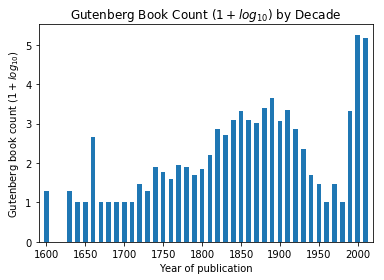

In [145]:
gxlabels = [p[0] for p in decade_logp1]
gyvalues = [p[1] for p in decade_logp1]
gwidth = 6
plt.bar(gxlabels, gyvalues, gwidth)
ax = plt.gca()
ax.set_title('Gutenberg Book Count ($1 + log_{10}$) by Decade')
ax.set_xlabel('Year of publication')
ax.set_ylabel('Gutenberg book count ($1 + log_{10}$)')
plt.xlim(xmin=1590, xmax=2020)
ax.xaxis.set_ticks(np.arange(1600, 2011, 50))
plt.show()

# Define Corpus

In [333]:
gcorpus = GutenbergCorpus(gbooks_valid
                          , num_books_per_decade=GUTENBERG_BOOKS_PER_DECADE
                         )

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(72791 unique tokens: ['_ad', '_ad_', '_aesop', '_almanack_', '_almanacks_']...) from 80 documents (total 1429573 corpus positions)
INFO:gensim.corpora.dictionary:discarding 37845 tokens: [('_ad_', 1), ('_almanacks_', 1), ('_alpha_', 1), ('_although', 1), ('_amant', 1), ('_ambo', 1), ('_anglice_', 1), ('_anglicus_', 1), ('_annas', 1), ('_annotation_', 1)]...
INFO:gensim.corpora.dictionary:keeping 34946 tokens which were in no less than 2 and no more than 40 (=50.0%) documents
DEBUG:gensim.corpora.dictionary:rebuilding dictionary, shrinking gaps
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(34946 unique tokens: ['_ad', '_aesop', '_almanack_', '_an_', '_and']...)


In [365]:
for decade in gcorpus.decades:
    print(f'{decade}: {gcorpus.selected_book_ids_by_decade[decade]}')

1600: [15835, 48594]
1630: [12259, 38417]
1640: [47462, 47462]
1650: [9198, 9198]
1660: [4170, 4168]
1670: [28010, 28010]
1680: [16335, 16335]
1690: [13274, 13274]
1700: [36587, 36587]
1710: [12381, 12381]
1720: [31673, 16299]
1730: [2108, 2822]
1740: [18635, 2116]
1750: [3355, 2119]
1760: [30099, 16747]
1770: [14611, 49742]
1780: [45757, 22487]
1790: [8639, 41144]
1800: [11866, 44408]
1810: [11203, 44281]
1820: [42482, 11460]
1830: [43540, 11903]
1840: [11454, 25633]
1850: [37516, 36124]
1860: [20647, 15819]
1870: [10014, 25725]
1880: [29134, 15924]
1890: [12905, 32976]
1900: [25107, 23411]
1910: [26377, 28470]
1920: [20779, 16684]
1930: [46222, 41622]
1940: [41651, 45185]
1950: [25034, 19780]
1960: [15158, 15158]
1970: [30557, 5]
1980: [4290, 4290]
1990: [1405, 1729]
2000: [21899, 3871]
2010: [34230, 32331]


In [334]:
gcorpus.decades

[1600,
 1630,
 1640,
 1650,
 1660,
 1670,
 1680,
 1690,
 1700,
 1710,
 1720,
 1730,
 1740,
 1750,
 1760,
 1770,
 1780,
 1790,
 1800,
 1810,
 1820,
 1830,
 1840,
 1850,
 1860,
 1870,
 1880,
 1890,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010]

In [335]:
gcorpus.get_time_seq()

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [336]:
gcorpus.selected_book_ids_by_decade

defaultdict(list,
            {1600: [15835, 48594],
             1630: [12259, 38417],
             1640: [47462, 47462],
             1650: [9198, 9198],
             1660: [4170, 4168],
             1670: [28010, 28010],
             1680: [16335, 16335],
             1690: [13274, 13274],
             1700: [36587, 36587],
             1710: [12381, 12381],
             1720: [31673, 16299],
             1730: [2108, 2822],
             1740: [18635, 2116],
             1750: [3355, 2119],
             1760: [30099, 16747],
             1770: [14611, 49742],
             1780: [45757, 22487],
             1790: [8639, 41144],
             1800: [11866, 44408],
             1810: [11203, 44281],
             1820: [42482, 11460],
             1830: [43540, 11903],
             1840: [11454, 25633],
             1850: [37516, 36124],
             1860: [20647, 15819],
             1870: [10014, 25725],
             1880: [29134, 15924],
             1890: [12905, 32976],
            

In [337]:
# Unused DTM params: alpha, lda_{min,max}_em_iter, lda_sequence_max_iter, top_chain_var
logging.basicConfig(level=logging.DEBUG)
gmodel = DtmModel(DTM_PATH
                  , gcorpus
                  , gcorpus.get_time_seq()
                  , num_topics=5
                  , id2word=gcorpus.dictionary
                  , initialize_lda=True)

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/19274_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/19274_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'wb', 'uri': '/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/19274_train-mult.dat'}
DEBUG:smart_open.smart_open_lib:encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'wb', 'fileobj': <_io.BufferedWriter name='/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/19274_train-mult.dat'>}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 34946 words to /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/19274_train-mult.dat.vocab
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'wb', 'uri': '/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/19274_train-mult.dat.voca

In [344]:
for i in range(0, num_topics):
    print ("Distribution of Topic %d %f" % (i, gmodel.gamma_[doc_number, i]))

Distribution of Topic 0 0.138458
Distribution of Topic 1 0.054126
Distribution of Topic 2 0.065588
Distribution of Topic 3 0.688575
Distribution of Topic 4 0.053254


In [360]:
for topicid in [0,1,2,3,4]: # 1900s
    print(gmodel.show_topic(topicid=topicid, time=28, topn=10))
    print()

[(0.004709813297933354, 'library'), (0.0030859186326109753, 'committee'), (0.0025127749895826833, 'wilson'), (0.0024379646463592013, 'college'), (0.002434622884332607, 'washington'), (0.0018991987382760123, 'today'), (0.0018580589476396114, 'libraries'), (0.0018556990426500722, 'national'), (0.0017765834621545381, 'cabinet'), (0.0016797862538621923, 'vol')]

[(0.013533164612376476, 'germany'), (0.004565220325777083, 'allies'), (0.0036153642431063365, 'trenches'), (0.002240150072473574, 'russians'), (0.0021046158194542074, 'count'), (0.002092974286787563, 'italian'), (0.0020876886599896006, 'steamer'), (0.001727233186679671, '_from'), (0.0016668122493052834, 'natives'), (0.0016150071120506861, 'coast')]

[(0.0067748156055602105, 'german'), (0.0066786960792193885, 'attack'), (0.003531100981064933, 'shelter'), (0.002722614545507283, 'supplies'), (0.0024242888029083146, 'emergency'), (0.0021613581423069, 'local'), (0.0021434309750827576, 'warning'), (0.0020908846526805306, 'guns'), (0.0018

In [386]:
[book['title'] for book in gcorpus.books if book['id'] in [1405, 1729]]

['The Deserted Woman', 'The Collection of Antiquities']

In [388]:
[book for book in gcorpus.books if book['id'] == 1729]

[{'author': 'Honore de Balzac',
  'content_lines': None,
  'error': '',
  'id': 1729,
  'path': '/Users/jmc/git/jaycoskey/Coskey_Metis/projects/Project4/data/gutenberg_books_en/aleph.gutenberg.org/1/7/2/1729/1729.zip',
  'title': 'The Deserted Woman',
  'year': '1999'}]

In [393]:
doc_num = 0
for decade in gcorpus.decades:
    for id in gcorpus.selected_book_ids_by_decade[decade]:
        book = [book for book in gcorpus.books if book['id'] == id][0]
        print(f'Doc #{doc_num}=Book ID #{id}')
        print(f'\t{book}')
        doc_num += 1

Doc #0=Book ID #15835
	{'id': 15835, 'path': '/Users/jmc/git/jaycoskey/Coskey_Metis/projects/Project4/data/gutenberg_books_en/aleph.gutenberg.org/1/5/8/3/15835/15835.zip', 'author': 'William Lilly', 'title': "William Lilly's History of His Life and Times", 'year': '1602', 'content_lines': None, 'error': ''}
Doc #1=Book ID #48594
	{'id': 48594, 'path': '/Users/jmc/git/jaycoskey/Coskey_Metis/projects/Project4/data/gutenberg_books_en/aleph.gutenberg.org/4/8/5/9/48594/48594-0.zip', 'author': 'Ernest Stuart Bates', 'title': 'Touring in 1600', 'year': '1600', 'content_lines': None, 'error': ''}
Doc #2=Book ID #12259
	{'id': 12259, 'path': '/Users/jmc/git/jaycoskey/Coskey_Metis/projects/Project4/data/gutenberg_books_en/aleph.gutenberg.org/1/2/2/5/12259/12259.zip', 'author': 'Daniel Defoe', 'title': 'Memoirs of a Cavalier', 'year': '1632', 'content_lines': None, 'error': ''}
Doc #3=Book ID #38417
	{'id': 38417, 'path': '/Users/jmc/git/jaycoskey/Coskey_Metis/projects/Project4/data/gutenberg_boo

In [398]:
doc_number = 74
num_topics = 5

for k in range(0, num_topics):
    print ("Distribution of Topic %d %f" % (k, gmodel.gamma_[doc_number, k]))

Distribution of Topic 0 0.113581
Distribution of Topic 1 0.651897
Distribution of Topic 2 0.043261
Distribution of Topic 3 0.099869
Distribution of Topic 4 0.091392


In [376]:
from gensim.matutils import hellinger

In [397]:
# vec_primary = [0.071460, 0.044956, 0.068991, 0.058845, 0.755748] # sweethearts_at_home
vec_primary = [0.059242, 0.733993, 0.022367, 0.119562, 0.064835]
min_dist = 100
min_doc_num = 100
min_vec_other = None
for doc_num in range(0, 80):
    if doc_num == 75:
        continue
    vec_other = [ gmodel.gamma_[doc_num, 0]
               , gmodel.gamma_[doc_num, 1]
               , gmodel.gamma_[doc_num, 2]
               , gmodel.gamma_[doc_num, 3]
               , gmodel.gamma_[doc_num, 4]
              ]
    dist = hellinger(vec_primary, vec_other)
    if dist < min_dist:
        min_dist = dist
        min_doc_num = doc_num
        min_vec_other = vec_other

print (f"Min_doc_num={min_doc_num}; dist={min_dist}; min_vec_other={min_vec_other}")

Min_doc_num=74; dist=0.09426715845723534; min_vec_other=[0.11358060316904314, 0.6518968277835198, 0.04326092786677336, 0.09986923687216961, 0.0913924043084941]


# EDA

valid_book_ids = []
book_errors = {}
for book_id_num, book_id in enumerate(get_book_ids(base_dir=GUTENBERG_DOWNLOAD_DIR)):
    book_path_info = get_book_path_info(book_id, base_dir=GUTENBERG_DOWNLOAD_DIR)
    if not book_path_info[0]:
        print(f'Error with book #{book_id}: {book_path_info[1]}')
        continue
    book_path = book_path_info[0]
    book = get_book_from_path(book_id, book_path)
    if len(book['error']) == 0:
        valid_book_ids.append(book_id)
    else:
        book_errors[book_id] = book['error']

len(valid_book_ids)

with open('valid_book_ids.txt', 'w') as f:
    for id in sorted(valid_book_ids):
        f.write(str(id) + '\n')

book_errors

# Latent Dirichlet Allocation (LDA)

In [211]:
ldamodel = test_lda()

Titles: ['Hacker Crackdown', 'United States Declaration of Independence', 'Helen of Troy and Other Poems', 'The Adventures of Pinocchio', 'Notes from the Underground', 'The Old Curiosity Shop', 'A Sentimental Journey through France and Italy', 'The Happy Prince']
Years: ['2012', '2015', '2008', '2006', '2008', '2008', '2015', '2015']


# Dynamic Topic Modeling (DTM)

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

In [399]:
# Sample data from the dtmmodel documentation
test_documents = [[u'senior', u'studios', u'studios', u'studios', u'creators', u'award'
              , u'mobile', u'currently', u'challenges', u'senior', u'summary'
              , u'senior', u'motivated', u'creative', u'senior', u'performs'
              , u'engineering', u'tasks', u'infrastructure', u'focusing', u'primarily'
              , u'programming', u'interaction', u'designers', u'engineers'
              , u'leadership', u'teams', u'teams', u'crews', u'responsibilities'
              , u'engineering', u'quality', u'functional', u'functional', u'teams'
              , u'organizing', u'prioritizing', u'technical', u'decisions'
              , u'engineering', u'participates', u'participates', u'reviews'
              , u'participates', u'hiring', u'conducting', u'interviews'
              , u'feedback', u'departments', u'define', u'focusing', u'engineering'
              , u'teams', u'crews', u'facilitate', u'engineering', u'departments'
              , u'deadlines', u'milestones', u'typically', u'spends', u'designing'
              , u'developing', u'updating', u'bugs', u'mentoring', u'engineers'
              , u'define', u'schedules', u'milestones', u'participating', u'reviews'
              , u'interviews', u'sized', u'teams', u'interacts', u'disciplines'
              , u'knowledge', u'skills', u'knowledge', u'knowledge', u'xcode'
              , u'scripting', u'debugging', u'skills', u'skills', u'knowledge'
              , u'disciplines', u'animation', u'networking', u'expertise', u'competencies'
              , u'oral', u'skills', u'management', u'skills', u'proven', u'effectively'
              , u'teams', u'deadline', u'environment', u'bachelor', u'minimum', u'shipped'
              , u'leadership', u'teams', u'location', u'resumes', u'jobs', u'candidates'
              , u'openings', u'jobs'],
             
             [u'maryland', u'client', u'producers', u'electricity'
              , u'operates', u'storage', u'utility', u'retail', u'customers', u'engineering'
              , u'consultant', u'maryland', u'summary', u'technical', u'technology'
              , u'departments', u'expertise', u'maximizing', u'output', u'reduces'
              , u'operating', u'participates', u'areas', u'engineering', u'conducts'
              , u'testing', u'solve', u'supports', u'environmental', u'understands'
              , u'objectives', u'operates', u'responsibilities', u'handles', u'complex'
              , u'engineering', u'aspects', u'monitors', u'quality', u'proficiency'
              , u'optimization', u'recommendations', u'supports', u'personnel'
              , u'troubleshooting', u'commissioning', u'startup', u'shutdown', u'supports'
              , u'procedure', u'operating', u'units', u'develops', u'simulations'
              , u'troubleshooting', u'tests', u'enhancing', u'solving', u'develops'
              , u'estimates', u'schedules', u'scopes', u'understands', u'technical'
              , u'management', u'utilize', u'routine', u'conducts', u'hazards', u'utilizing'
              , u'hazard', u'operability', u'methodologies', u'participates', u'startup'
              , u'reviews', u'pssr', u'participate', u'teams', u'participate', u'regulatory'
              , u'audits', u'define', u'scopes', u'budgets', u'schedules', u'technical'
              , u'management', u'environmental', u'awareness', u'interfacing', u'personnel'
              , u'interacts', u'regulatory', u'departments', u'input', u'objectives'
              , u'identifying', u'introducing', u'concepts', u'solutions', u'peers'
              , u'customers', u'coworkers', u'knowledge', u'skills', u'engineering'
              , u'quality', u'engineering', u'commissioning', u'startup', u'knowledge'
              , u'simulators', u'technologies', u'knowledge', u'engineering', u'techniques'
              , u'disciplines', u'leadership', u'skills', u'proven', u'engineers', u'oral'
              , u'skills', u'technical', u'skills', u'analytically', u'solve', u'complex'
              , u'interpret', u'proficiency', u'simulation', u'knowledge', u'applications'
              , u'manipulate', u'applications', u'engineering', u'calculations', u'programs'
              , u'matlab', u'excel', u'independently', u'environment', u'proven', u'skills'
              , u'effectively', u'multiple', u'tasks', u'planning', u'organizational'
              , u'management', u'skills', u'rigzone', u'jobs', u'developer', u'exceptional'
              , u'strategies', u'junction', u'exceptional', u'strategies', u'solutions'
              , u'solutions', u'biggest', u'insurers', u'operates', u'investment']
             
             , [u'vegas', u'tasks', u'electrical', u'contracting', u'expertise', u'virtually'
                , u'electrical', u'developments', u'institutional', u'utilities', u'technical'
                , u'experts', u'relationships', u'credibility', u'contractors', u'utility'
                , u'customers', u'customer', u'relationships', u'consistently', u'innovations'
                , u'profile', u'construct', u'envision', u'dynamic', u'complex', u'electrical'
                , u'management', u'grad', u'internship', u'electrical', u'engineering'
                , u'infrastructures', u'engineers', u'documented', u'management', u'engineering'
                , u'quality', u'engineering', u'electrical', u'engineers', u'complex', u'distribution'
                , u'grounding', u'estimation', u'testing', u'procedures', u'voltage', u'engineering'
                , u'troubleshooting', u'installation', u'documentation', u'bsee', u'certification'
                , u'electrical', u'voltage', u'cabling', u'electrical', u'engineering', u'candidates'
                , u'electrical', u'internships', u'oral', u'skills', u'organizational'
                , u'prioritization', u'skills', u'skills', u'excel', u'cadd', u'calculation'
                , u'autocad', u'mathcad', u'skills', u'skills', u'customer', u'relationships'
                , u'solving', u'ethic', u'motivation', u'tasks', u'budget', u'affirmative'
                , u'diversity', u'workforce', u'gender', u'orientation', u'disability', u'disabled'
                , u'veteran', u'vietnam', u'veteran', u'qualifying', u'veteran', u'diverse'
                , u'candidates', u'respond', u'developing', u'workplace', u'reflects'
                , u'diversity', u'communities', u'reviews', u'electrical', u'contracting'
                , u'southwest', u'electrical', u'contractors']
             
             , [u'intern', u'electrical', u'engineering', u'idexx', u'laboratories', u'validating'
                , u'idexx', u'integrated', u'hardware', u'entails', u'planning', u'debug'
                , u'validation', u'engineers', u'validation', u'methodologies', u'healthcare'
                , u'platforms', u'brightest', u'solve', u'challenges', u'innovation'
                , u'technology', u'idexx', u'intern', u'idexx', u'interns', u'supplement'
                , u'interns', u'teams', u'roles', u'competitive', u'interns', u'idexx'
                , u'interns', u'participate', u'internships', u'mentors', u'seminars'
                , u'topics', u'leadership', u'workshops', u'relevant', u'planning', u'topics'
                , u'intern', u'presentations', u'mixers', u'applicants', u'ineligible'
                , u'laboratory', u'compliant', u'idexx', u'laboratories', u'healthcare'
                , u'innovation', u'practicing', u'veterinarians', u'diagnostic', u'technology'
                , u'idexx', u'enhance', u'veterinarians', u'efficiency', u'economically'
                , u'idexx', u'worldwide', u'diagnostic', u'tests', u'tests', u'quality'
                , u'headquartered', u'idexx', u'laboratories', u'employs', u'customers'
                , u'qualifications', u'applicants', u'idexx', u'interns', u'potential'
                , u'demonstrated', u'portfolio', u'recommendation', u'resumes', u'marketing'
                , u'location', u'americas', u'verification', u'validation', u'schedule'
                , u'overtime', u'idexx', u'laboratories', u'reviews', u'idexx', u'laboratories'
                , u'nasdaq', u'healthcare', u'innovation', u'practicing', u'veterinarians']
             
             , [u'location', u'duration', u'temp', u'verification', u'validation', u'tester'
                , u'verification', u'validation', u'middleware', u'specifically', u'testing'
                , u'applications', u'clinical', u'laboratory', u'regulated', u'environment'
                , u'responsibilities', u'complex', u'hardware', u'testing', u'clinical'
                , u'analyzers', u'laboratory', u'graphical', u'interfaces', u'complex'
                , u'sample', u'sequencing', u'protocols', u'developers', u'correction'
                , u'tracking', u'tool', u'timely', u'troubleshoot', u'testing', u'functional'
                , u'manual', u'automated', u'participate', u'ongoing', u'testing', u'coverage'
                , u'planning', u'documentation', u'testing', u'validation', u'corrections'
                , u'monitor', u'implementation', u'recurrence', u'operating', u'statistical'
                , u'quality', u'testing', u'global', u'multi', u'teams', u'travel', u'skills'
                , u'concepts', u'waterfall', u'agile', u'methodologies', u'debugging'
                , u'skills', u'complex', u'automated', u'instrumentation', u'environment'
                , u'hardware', u'mechanical', u'components', u'tracking', u'lifecycle'
                , u'management', u'quality', u'organize', u'define', u'priorities'
                , u'organize', u'supervision', u'aggressive', u'deadlines', u'ambiguity'
                , u'analyze', u'complex', u'situations', u'concepts', u'technologies'
                , u'verbal', u'skills', u'effectively', u'technical', u'clinical'
                , u'diverse', u'strategy', u'clinical', u'chemistry', u'analyzer'
                , u'laboratory', u'middleware', u'basic', u'automated', u'testing'
                , u'biomedical', u'engineering', u'technologists', u'laboratory'
                , u'technology', u'availability', u'click', u'attach']
             
             ,[u'scientist', u'linux', u'asrc', u'scientist', u'linux', u'asrc'
               , u'technology', u'solutions', u'subsidiary', u'asrc', u'engineering'
               , u'technology', u'contracts', u'multiple', u'agencies', u'scientists'
               , u'engineers', u'management', u'personnel', u'allows', u'solutions'
               , u'complex', u'aeronautics', u'aviation', u'management', u'aviation'
               , u'engineering', u'hughes', u'technical', u'technical', u'aviation'
               , u'evaluation', u'engineering', u'management', u'technical', u'terminal'
               , u'surveillance', u'programs', u'currently', u'scientist', u'travel'
               , u'responsibilities', u'develops', u'technology', u'modifies'
               , u'technical', u'complex', u'reviews', u'draft', u'conformity'
               , u'completeness', u'testing', u'interface', u'hardware', u'regression'
               , u'impact', u'reliability', u'maintainability', u'factors'
               , u'standardization', u'skills', u'travel', u'programming'
               , u'linux', u'environment', u'cisco', u'knowledge', u'terminal'
               , u'environment', u'clearance', u'clearance', u'input', u'output'
               , u'digital', u'automatic', u'terminal', u'management', u'controller'
               , u'termination', u'testing', u'evaluating', u'policies', u'procedure'
               , u'interface', u'installation', u'verification', u'certification'
               , u'core', u'avionic', u'programs', u'knowledge', u'procedural'
               , u'testing', u'interfacing', u'hardware', u'regression', u'impact'
               , u'reliability', u'maintainability', u'factors', u'standardization'
               , u'missions', u'asrc', u'subsidiaries', u'affirmative', u'employers'
               , u'applicants', u'disability', u'veteran', u'technology', u'location'
               , u'airport', u'bachelor', u'schedule', u'travel', u'contributor'
               , u'management', u'asrc', u'reviews']
             
             , [u'technical', u'solarcity', u'niche', u'vegas', u'overview'
                , u'resolving', u'customer', u'clients', u'expanding', u'engineers'
                , u'developers', u'responsibilities', u'knowledge', u'planning'
                , u'adapt', u'dynamic', u'environment', u'inventive', u'creative'
                , u'solarcity', u'lifecycle', u'responsibilities', u'technical'
                , u'analyzing', u'diagnosing', u'troubleshooting', u'customers'
                , u'ticketing', u'console', u'escalate', u'knowledge', u'engineering'
                , u'timely', u'basic', u'phone', u'functionality', u'customer'
                , u'tracking', u'knowledgebase', u'rotation', u'configure'
                , u'deployment', u'sccm', u'technical', u'deployment', u'deploy'
                , u'hardware', u'solarcity', u'bachelor', u'knowledge', u'dell'
                , u'laptops', u'analytical', u'troubleshooting', u'solving'
                , u'skills', u'knowledge', u'databases', u'preferably', u'server'
                , u'preferably', u'monitoring', u'suites', u'documentation'
                , u'procedures', u'knowledge', u'entries', u'verbal', u'skills'
                , u'customer', u'skills', u'competitive', u'solar', u'package'
                , u'insurance', u'vacation', u'savings', u'referral', u'eligibility'
                , u'equity', u'performers', u'solarcity', u'affirmative'
                , u'diversity', u'workplace', u'applicants', u'orientation'
                , u'disability', u'veteran', u'careerrookie']
             
             , [u'embedded', u'exelis', u'junction', u'exelis', u'embedded'
                , u'acquisition', u'networking', u'capabilities', u'classified'
                , u'customer', u'motivated', u'develops', u'tests', u'innovative'
                , u'solutions', u'minimal', u'supervision', u'paced', u'environment'
                , u'enjoys', u'assignments', u'interact', u'multi', u'disciplined'
                , u'challenging', u'focused', u'embedded', u'developments'
                , u'spanning', u'engineering', u'lifecycle', u'specification'
                , u'enhancement', u'applications', u'embedded', u'freescale'
                , u'applications', u'android', u'platforms', u'interface'
                , u'customers', u'developers', u'refine', u'specifications'
                , u'architectures', u'java', u'programming', u'scripts'
                , u'python', u'debug', u'debugging', u'emulators', u'regression'
                , u'revisions', u'specialized', u'setups', u'capabilities'
                , u'subversion', u'technical', u'documentation', u'multiple'
                , u'engineering', u'techexpousa', u'reviews']
             
             , [u'modeler', u'semantic', u'modeling', u'models', u'skills', u'ontology'
                , u'resource', u'framework', u'schema', u'technologies', u'hadoop'
                , u'warehouse', u'oracle', u'relational', u'artifacts', u'models'
                , u'dictionaries', u'models', u'interface', u'specifications'
                , u'documentation', u'harmonization', u'mappings', u'aligned'
                , u'coordinate', u'technical', u'peer', u'reviews', u'stakeholder'
                , u'communities', u'impact', u'domains', u'relationships'
                , u'interdependencies', u'models', u'define', u'analyze', u'legacy'
                , u'models', u'corporate', u'databases', u'architectural', u'alignment'
                , u'customer', u'expertise', u'harmonization', u'modeling', u'modeling'
                , u'consulting', u'stakeholders', u'quality', u'models', u'storage'
                , u'agile', u'specifically', u'focus', u'modeling', u'qualifications'
                , u'bachelors', u'accredited', u'modeler', u'encompass', u'evaluation'
                , u'skills', u'knowledge', u'modeling', u'techniques', u'resource'
                , u'framework', u'schema', u'technologies', u'unified', u'modeling'
                , u'technologies', u'schemas', u'ontologies', u'sybase', u'knowledge'
                , u'skills', u'interpersonal', u'skills', u'customers', u'clearance'
                , u'applicants', u'eligibility', u'classified', u'clearance', u'polygraph'
                , u'techexpousa', u'solutions', u'partnership', u'solutions', u'integration']
             
             , [u'technologies', u'junction', u'develops', u'maintains', u'enhances'
                , u'complex', u'diverse', u'intensive', u'analytics', u'algorithm'
                , u'manipulation', u'management', u'documented', u'individually'
                , u'reviews', u'tests', u'components', u'adherence', u'resolves'
                , u'utilizes', u'methodologies', u'environment', u'input', u'components'
                , u'hardware', u'offs', u'reuse', u'cots', u'gots', u'synthesis'
                , u'components', u'tasks', u'individually', u'analyzes', u'modifies'
                , u'debugs', u'corrects', u'integrates', u'operating', u'environments'
                , u'develops', u'queries', u'databases', u'repositories', u'recommendations'
                , u'improving', u'documentation', u'develops', u'implements', u'algorithms'
                , u'functional', u'assists', u'developing', u'executing', u'procedures'
                , u'components', u'reviews', u'documentation', u'solutions', u'analyzing'
                , u'conferring', u'users', u'engineers', u'analyzing', u'investigating'
                , u'areas', u'adapt', u'hardware', u'mathematical', u'models', u'predict'
                , u'outcome', u'implement', u'complex', u'database', u'repository'
                , u'interfaces', u'queries', u'bachelors', u'accredited', u'substituted'
                , u'bachelors', u'firewalls', u'ipsec', u'vpns', u'technology'
                , u'administering', u'servers', u'apache', u'jboss', u'tomcat'
                , u'developing', u'interfaces', u'firefox', u'internet', u'explorer'
                , u'operating', u'mainframe', u'linux', u'solaris', u'virtual'
                , u'scripting', u'programming', u'oriented', u'programming', u'ajax'
                , u'script', u'procedures', u'cobol', u'cognos', u'fusion', u'focus'
                , u'html', u'java', u'java', u'script', u'jquery', u'perl', u'visual'
                , u'basic', u'powershell', u'cots', u'cots', u'oracle', u'apex'
                , u'integration', u'competitive', u'package', u'bonus', u'corporate'
                , u'equity', u'tuition', u'reimbursement', u'referral', u'bonus'
                , u'holidays', u'insurance', u'flexible', u'disability', u'insurance'
                , u'technologies', u'disability', u'accommodation', u'recruiter', u'techexpousa']
            ]

In [404]:
dtm_corpus = DTMcorpus(test_documents)

INFO:gensim.corpora.textcorpus:Initializing dictionary
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(546 unique tokens: ['animation', 'award', 'bachelor', 'bugs', 'candidates']...) from 10 documents (total 1112 corpus positions)


In [405]:
time_seq = [3, 7]  # first 3 documents are from time slice one 
#  and the other 7 are from the second time slice.

In [406]:
type(dtm_corpus)

__main__.DTMcorpus

In [408]:
dtm_model = DtmModel(DTM_PATH
                  , dtm_corpus
                  , time_seq
                  , num_topics=20
                  , id2word=dtm_corpus.dictionary
                  , initialize_lda=True)

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/ec66ae_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/ec66ae_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'wb', 'uri': '/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/ec66ae_train-mult.dat'}
DEBUG:smart_open.smart_open_lib:encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'wb', 'fileobj': <_io.BufferedWriter name='/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/ec66ae_train-mult.dat'>}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 546 words to /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/ec66ae_train-mult.dat.vocab
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'wb', 'uri': '/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/ec66ae_train-mult.dat.

In [410]:
doc_number = 1
num_topics = 2

for i in range(0, num_topics):
    print ("Distribution of Topic %d %f" % (i, dtm_model.gamma_[doc_number, i]))

Distribution of Topic 0 0.000060
Distribution of Topic 1 0.000060


# DIM Example

In [416]:
dim_model = DtmModel(DTM_PATH, dtm_corpus, time_seq, num_topics=2,
                 id2word=dtm_corpus.dictionary, initialize_lda=True, model='fixed')

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/a998b1_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/a998b1_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'wb', 'uri': '/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/a998b1_train-mult.dat'}
DEBUG:smart_open.smart_open_lib:encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'wb', 'fileobj': <_io.BufferedWriter name='/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/a998b1_train-mult.dat'>}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 546 words to /var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/a998b1_train-mult.dat.vocab
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'wb', 'uri': '/var/folders/s2/y23_8q5n12d343lf0z44j9mm0000gn/T/a998b1_train-mult.dat.

In [417]:
document_no = 1 #document 2
topic_no = 1 #topic number 2
time_slice = 0 #time slice 1

dim_model.influences_time[time_slice][document_no][topic_no]

0.008210686237285747